<a href="https://colab.research.google.com/github/Mark-Barbaric/IBM_Machine_Learning_Certificate/blob/dl_week4/Deep_Learning_and_Reinforcement_Learning/week4/bulding_a_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Building a CNN**


## A mission to automate monitoring of flowering

Climate warning is causing a lot of changes in the timing and duration of flowering seasons, making it hard for the flower planting company to monitor the growing of various species. To study the changes, the company's biologists are monitoring the plants in small permanently marked areas and performing manual collection and analysis of the plant phenology details.

You are now hired by the company as a Data Scientist to help automate the monitoring process. The first step of your mission is to create a flower type identification system, so that it could greatly reduce the time and cost of tracking the flowers on an indivifual level.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/flowershop.jpeg" width="80%"></center>


In this lab, we will tie together everything we've learned in previous CNN labs and apply our new found skills in a object recognition task.

This lab takes concepts learned in this Deep Learning and Reinforcement Learning course and applies them in the creation of a CNN model.

We will be implementing a model that classifies images employing multiple convolutional **filters** for multi-**channel**/RGB images, adding **padding** to images to preserve image sizes/capture edge data, determining the best **stride** to use with the convolutional filters, passing that data through **activation functions** such as ReLU and **pooling** layers, and **flattenning** our results to obtain classes using **categorical cross entropy**.


## Table of Contents

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
        </ol>     
    </li>
    <li>
        <a href="#Example: Classifying Flowers">Example: Classifying Flowers</a>
        <ol>
            <li><a href="#Importing data">Importing data</a></li>
            <li><a href="#Building a classifier">Building a classifier</a></li>
            <li><a href="#Prediction!">Prediction!</a></li>
        </ol>   
    </li>
</ol>


## Objectives

After completing this lab you will be able to:

*   Explain how a convolution works on images
*   Understand the purposes of different kernels that exist
*   Apply kernels to images and obtain a useful result


In [1]:
!pip install opencv-python==4.5.5.62 skillsnetwork

Reason for being yanked: deprecated, use 4.5.5.64
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [29]:
import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pathlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image, ImageOps
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Defining Helper Functions


This function helps visualize the feature maps of the layers in a classifier.


In [3]:
def plot_activations_multilayer(num_layers, images_per_row, classifier, activations):
    layer_names = []
    for layer in classifier.layers[:num_layers]:
        layer_names.append(layer.name + ' layer')  # Names of the layers, so you can have them as part of your plot
    for layer_name, layer_activation in zip(layer_names, activations):  # Displays the feature maps
        n_features = layer_activation.shape[-1]  # Number of features in the feature map
        size = layer_activation.shape[1]  # The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :,
                                                 col * images_per_row + row]
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 2. / size
        plt.figure(figsize=(scale*display_grid.shape[1],
                            scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Example: Classifying Flowers


We will use our flower images from the image convolution lab. However, this time, we want to use them to train a CNN model for classification. Hence, we will utilize a training and test set.
https://www.tensorflow.org/tutorials/load_data/images


### Importing data

Lets take a look at the flowers dataset from tensorflow, retrieved from here: [https://www.tensorflow.org/datasets/catalog/tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)


In [4]:
import skillsnetwork

dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/datasets/flower_photos.tgz"
await skillsnetwork.prepare(dataset_url, overwrite=True)

  0%|          | 0/3677 [00:00<?, ?it/s]

Saved to '.'


In [5]:
data_dir = Path("flower_photos")

for folder in data_dir.glob('[!LICENSE]*'):
    print('The', folder.name, 'folder has',
          len(list(folder.glob('*.jpg'))), 'pictures')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count, 'total images')

The dandelion folder has 898 pictures
The roses folder has 641 pictures
The daisy folder has 633 pictures
The tulips folder has 799 pictures
The sunflowers folder has 699 pictures
3670 total images


In [6]:
img_width = 150
img_height = 150

batch_size = 64
epochs = 10

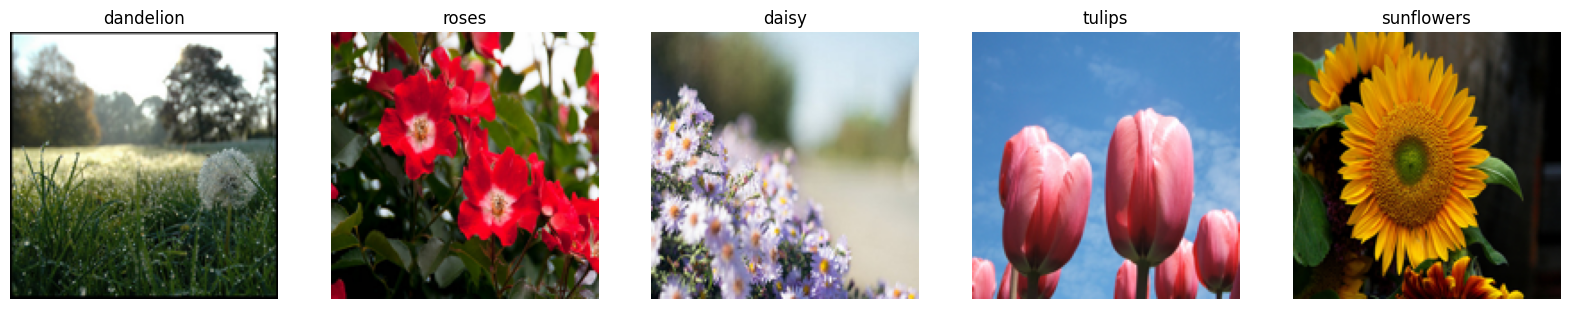

In [7]:
pics = []
pics_arr = []
p_class = []

plt.figure(figsize=(20, 5))

for idx, folder in enumerate(data_dir.glob('[!LICENSE]*')):
    cat = list(data_dir.glob(folder.name + '/*'))
    pic = PIL.Image.open(str(cat[0])).resize((img_width, img_height))
    pic_arr = np.array(pic)
    clss = folder.name

    plt.subplot(1,5,idx+1)
    plt.imshow(pic)
    plt.title(clss)
    plt.axis('off')

    pics.append(pic)
    pics_arr.append(pic_arr)
    p_class.append(clss)

Let's create a train set using the `ImageDataGenerator` and `flow_from_directory` functions from `keras.utils`.


In [8]:
train_gen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_set = train_gen.flow_from_directory(
    directory=data_dir,
    seed=10,
    class_mode="sparse",
    batch_size=batch_size,
    shuffle=True,
    target_size=(img_height, img_width),
    subset='training'
)

Found 2939 images belonging to 5 classes.


In [9]:
validation_gen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

validation_set = validation_gen.flow_from_directory(
    directory=data_dir,
    seed=10,
    class_mode="sparse",
    batch_size=batch_size,
    shuffle=True,
    target_size=(img_height, img_width),
    subset="validation"
)

Found 731 images belonging to 5 classes.


In [10]:
class_names = {
    y: x for x, y in validation_set.class_indices.items()
}

In [11]:
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

### Building a classifier


In [24]:
input_shape = (img_width, img_height, 3)

In [15]:
classifier = Sequential()

In [25]:
classifier.add(
    Input(input_shape,),
    Conv2D(
        32,
        (5, 5),
        padding="same",
        activation="relu"
    )
)
classifier.add(
    MaxPooling2D(
        pool_size=(2, 2)
    )
)
classifier.add(
    Conv2D(
        64,
        (3, 3),
        padding="same",
        activation="relu"
    )
)
classifier.add(
    MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2)
    )
)

In [26]:
classifier.add(
    Conv2D(
        32,
         (3, 3),
        padding="same",
        activation="relu")
)
classifier.add(
    MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2)
    )
)
classifier.add(
    Conv2D(
        32,
        (3, 3),
        padding="same",
        activation="relu"
    )
)
classifier.add(
    MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2)
    )
)

In [28]:
classifier.build((img_width, img_height, 3))
classifier.summary()

ValueError: Sequential model 'sequential_1' has already been configured to use input shape (None, 150, 150, 3). You cannot build it with input_shape (150, 150, 3)

Let's try to see how the layers look so far when applied on a sample image without training (call the `predict` method directly on the **img_tensor**.
